### Question 3

I chose to implement Google's PageRank centrality measure. 

All code is my own. I used https://pi.math.cornell.edu/~mec/Winter2009/RalucaRemus/Lecture3/lecture3.html as a reference.

In [20]:
import networkx as nx
import numpy as np
import copy as cp

#### a) Implementing my own version of PageRank

In [13]:
'''
Inputs
------
G: Networkx graph
n: node for which to compute centrality (if None, compute for all nodes), default: None
p: damping factor (p in range (0,1)), default: 0.15
max_iter: how many iterations before returning centrality, default: 100

Outputs
-------
centrality_dict: dictionary of nodes -> centrality OR single_node_centrality 
'''
def my_pagerank(G, n=None, p=0.15, max_iter=100):

    # handle non-NetworkX graph
    if not isinstance (G, nx.Graph):
        return 'Graph G is not a NetworkX graph.' 
    
    # if G is an undirected graph, convert it to a directed graph with 2 directed edges for each undirected edge
    if not nx.is_directed(G):
        G = G.to_directed()

    order = G.order()

    # avoid divide by 0 errors
    if order == 0:
        return 'Graph G has no nodes.'

    # handle graph with no connectivity
    if G.size() == 0 and n == None:
        return {k:(1/order) for k in range(order)}
    elif G.size() == 0:
        return 1/order

    # initialize centralities to all be the same (normalized {0, 1})
    centrality = np.full((order,1), 1/order) 

    # create matrix A - transition matrix showing importance that each node gives to other nodes
    A = np.zeros((order, order))
    for node1 in range(order):
        for node2 in range(order):
            if node1 in list(G.neighbors(node2)):
                deg = G.out_degree[node2]
                A[node1][node2] = 1 / deg # this is a safe division, as we have checked if node2 has neighbors

    # create matrix B - initialized to initial centralities
    B = np.full((order, order), 1 / order)
    
    # create matrix PR(A) - add in random "surfing" between nodes
    PRA = (1 - p) * A + p * B

    # multiply centralities by PR(A) until convergence
    for i in range(max_iter):
        old_centrality = cp.deepcopy(centrality)
        centrality = np.matmul(PRA, centrality)

        # if we converge (to 6 decimal places), stop iterating
        if np.array_equal(np.around(centrality, decimals=6), np.around(old_centrality, decimals=6)):
            break
        
    centrality_dict = {}
    for i, c in zip(range(order), centrality):
        centrality_dict[i] = c[0]

    # handle cases where n is not in G
    if n != None:
        try:   
            return centrality_dict[n]
        except LookupError as e:
            return 'Node not found! Exception: ' + str(e)
    return centrality_dict
    

#### b) Error handling

My function handles cases where:
- node n is not in the graph
- graph G is not a NetworkX graph
- graph G has no connectivity
- graph order is 0 (avoids divide by 0 errors)
- graph G is an undirected graph (converts to a directed graph, as PageRank deals with directed graphs)

#### c) Comparing my implementation to nx.pagerank()

Note: for testing purposes, I output the centralities of *all* nodes. My function can also take in a single node and return only its centrality, as per the specifications.

In [6]:
# Test input 1: graph with no connectivity
G1 = nx.empty_graph(5)

print('Test 1:')
print(my_pagerank(G1))
print(nx.pagerank(G1))
print('')

# Test input 2: simple directed graph
G2 = nx.DiGraph()
G2.add_edges_from([(0,1), (0, 2), (1, 3), (1, 2), (2, 0), (3, 2)])

print('Test 2:')
print(my_pagerank(G2))
print(nx.pagerank(G2))
print('')

# Test input 3: generated Erdos-Renyi graph
G3 = nx.erdos_renyi_graph(10, 0.5, directed=True)

print('Test 3:')
print(my_pagerank(G3))
print(nx.pagerank(G3))
print('')

# Test input 4: random graph with 6 nodes and 12 edges 
G4 = nx.gnm_random_graph(6, 12, directed=True)

print('Test 4:')
print(my_pagerank(G4))
print(nx.pagerank(G4))
print('')



Test 1:
{0: 0.2, 1: 0.2, 2: 0.2, 3: 0.2, 4: 0.2}
{0: 0.2, 1: 0.2, 2: 0.2, 3: 0.2, 4: 0.2}

Test 2:
{0: 0.34261241733725145, 1: 0.1831101432939232, 2: 0.35895554159986254, 3: 0.11532189776896119}
{0: 0.34261184962004987, 1: 0.18311051092969968, 2: 0.35895597976933946, 3: 0.11532165968091102}

Test 3:
{0: 0.12194692787315292, 1: 0.11729389316178115, 2: 0.07473312202662517, 3: 0.07540086826559142, 4: 0.10754161213318694, 5: 0.11255432493171916, 6: 0.07608872060307496, 7: 0.1012088587425205, 8: 0.14726675899075153, 9: 0.06596491327159594}
{0: 0.1219469037724637, 1: 0.11729357108573432, 2: 0.07473346642379539, 3: 0.07540058936295946, 4: 0.1075414975932108, 5: 0.11255422414916058, 6: 0.07608899628654991, 7: 0.10120898804045304, 8: 0.14726681513346235, 9: 0.06596494815221039}

Test 4:
{0: 0.21671263694782938, 1: 0.08549777108081874, 2: 0.23420051742063588, 3: 0.12984779381788222, 4: 0.024999999999999988, 5: 0.3087412807328333}
{0: 0.21671211804360327, 1: 0.08549767357096316, 2: 0.234200204973

#### Discussion of comparison of implementations

For the most part, my implementation of PageRank output the same values as the NetworkX implemenation (rounded to about 5 or 6 decimal places). I believe that the small differences between the values are due to optimizations that the built-in function has that I did not include in my rudimentary implementation. 

#### d) Testing a centrality measure function for robustness

I interpreted this question as a test of an implementation of a given centrality measure for both error-handling and for correctness (with the corresponding built-in implementation used as an oracle).

In [23]:
'''
Takes an implementation of a centrality measure and tests it for:
    a. Robustness - common edge cases that could cause exceptions
    b. Correctness - test the implementation against the built-in function (provided by function caller) on a few graphs

Assumes that all exceptions in the implementation are caught and returned as error messages. 

Inputs
------
impl: implementation of a centrality measure (type - function)
measure: corresponding built-in centrality measure (type - function)

'''
def test_centrality_impl(impl, measure):

    # robustness checks
    try:
        print('Trying a graph with no connectivity...')
        print('    PASSED! Output: ' + str(impl(nx.empty_graph(5), 2)) + '\n')
    except:
        print('    FAILED! Implementation threw an uncaught exception when graph with no connectivity was provided\n')

    try:
        print('Trying an input that is not a NetworkX graph...')
        print('    PASSED! Output: ' + str(impl('not a graph', 2)) + '\n')
    except:
        print('    FAILED! Implementation threw an uncaught exception when provided a non-graph object\n')

    try:
        print('Trying to get centrality for a node that is not in the graph...')
        print('    PASSED! Output: ' + str(impl(nx.DiGraph(incoming_graph_data=[(0,1), (0, 2), (1, 3), (1, 2), (2, 0), (3, 2)]), 7)) + '\n')
    except:
        print('    FAILED! Implementation threw an uncaught exception when provided a node that is not in the graph\n')

    # correctness checks
    
    # Test input 1: simple directed graph
    G1 = nx.DiGraph()
    G1.add_edges_from([(0,1), (0, 2), (1, 3), (1, 2), (2, 0), (3, 2)])

    if measure(G1) != impl(G1):
        print('FAILED! Outputs differ for graph ' + str(G1) + '.')
        print('    Outputs:')
        print('    Implementation: ' + str(impl(G1)))
        print('    Built-in: ' + str(measure(G1)) + '\n')
    
    # Test input 2: generated Erdos-Renyi graph
    G2 = nx.erdos_renyi_graph(10, 0.5, directed=True)

    if measure(G2) != impl(G2):
        print('FAILED! Outputs differ for Erdos-Renyi graph.')
        print('    Outputs:')
        print('    Implementation: ' + str(impl(G2)))
        print('    Built-in: ' + str(measure(G2)) + '\n')
    
    # Test input 3: random graph with 6 nodes and 12 edges 
    G3 = nx.gnm_random_graph(6, 12, directed=True)

    if nx.pagerank(G3) != impl(G3):
        print('FAILED! Outputs differ for random directed graph with 6 nodes and 12 edges.')
        print('    Outputs:')
        print('    Implementation: ' + str(impl(G3)))
        print('    Built-in: ' + str(measure(G3)) + '\n')


# example use of test_centrality_impl
test_centrality_impl(my_pagerank, nx.pagerank)
    

Trying a graph with no connectivity...
    PASSED! Output: 0.2

Trying an input that is not a NetworkX graph...
    PASSED! Output: Graph G is not a NetworkX graph.

Trying to get centrality for a node that is not in the graph...
    PASSED! Output: Node not found! Exception: 7

FAILED! Outputs differ for graph DiGraph with 4 nodes and 6 edges.
    Outputs:
    Implementation: {0: 0.34261241733725145, 1: 0.1831101432939232, 2: 0.35895554159986254, 3: 0.11532189776896119}
    Built-in: {0: 0.34261184962004987, 1: 0.18311051092969968, 2: 0.35895597976933946, 3: 0.11532165968091102}

FAILED! Outputs differ for Erdos-Renyi graph.
    Outputs:
    Implementation: {0: 0.1585596158893263, 1: 0.05452725675665643, 2: 0.04994958069534864, 3: 0.12676422872292997, 4: 0.12033925206546031, 5: 0.13767891128601067, 6: 0.1302171808597201, 7: 0.10151152241945939, 8: 0.05705195786064954, 9: 0.06340049344443849}
    Built-in: {0: 0.15855981296682367, 1: 0.05452737691941095, 2: 0.04994937864433871, 3: 0.12

#### Why I chose the test cases for test_centrality_impl

I chose three baseline robustness checks - handling a case where G is not a graph, handling a graph with no connectivity, and handling a function call with a node that is not in graph G. I chose these checks because they are universal for centrality measures - other robustness checks would require some knowledge of the implementation of the centrality measure. 

As for correctness, I chose one simple graph that I constructed, one generated Erdos-Renyi graph, and one randomly generated graph with 6 nodes and 12 edges. These three simple checks give the user an idea of the performance of their implementation against the built-in implementation. One is simple and contrived, one is a well-known graph structure, and one is a random graph (so the test could be run many times to check different outputs).


### Question 4

All code is my own. I used https://networkx.org/ and https://pypi.org/project/beautifulsoup4/ as references.

In [15]:
from bs4 import BeautifulSoup
import requests
import networkx as nx
import copy as cp

#### a) Scraping a department's courses

All code is my own. I used https://networkx.org/ and https://pypi.org/project/beautifulsoup4/ as references.

In [16]:
'''
Get URL to department catalog from department code. If the code does not exist, raise an error. 

Inputs
------
dept_code: department code (codes can be found at https://catalog.northeastern.edu/course-descriptions/). Example: MATH for Mathematics.

Outputs
-------
url: url to the department course catalog
'''
def dept_code_to_url(dept_code: str) -> str:
    catalog_res = requests.get('https://catalog.northeastern.edu/course-descriptions/')
    catalog_html = catalog_res.text
    catalog_soup = BeautifulSoup(catalog_html)
    
    url = '/course-descriptions/' + dept_code + '/'
    if url in [x['href'] for x in catalog_soup.find_all('a', href=True)]:
        return 'https://catalog.northeastern.edu' + url
                
    raise ValueError('No department found with the code ' + dept_code)
            
'''
Create a mapping of all courses in a given department to their prerequisites. Return an empty dictionary if department does not exist. 

Inputs
------
dept_code: department code (codes can be found at https://catalog.northeastern.edu/course-descriptions/). Example: MATH for Mathematics.

Outputs
-------
courses_to_prereqs: dictionary with courses as keys and lists of prerequisites as values
'''
def get_prereqs(dept_code: str) -> list:
    try:
        href = dept_code_to_url(dept_code)
    except ValueError as e:
        return {}
    
    dept_res = requests.get(href)
    dept_html = dept_res.text
    dept_soup = BeautifulSoup(dept_html)

    courses_to_prereqs = {}

    course_descs_soup = dept_soup.find('div', attrs={'class' : 'sc_sccoursedescs'})
    
    for course in course_descs_soup.find_all('div', attrs={'class' : 'courseblock'}):
        course_code = course.find('p', attrs={'class' : 'courseblocktitle'}).text.split('.')[0].replace(u'\xa0', '')
        prereqs = []
        for extra in course.find_all('p', attrs={'class' : 'courseblockextra'}):
            if 'Prerequisite(s)' in extra.text:
                for link in extra.find_all('a', href=True):
                    prereqs.append(link.text.replace(u'\xa0', ''))
        courses_to_prereqs[course_code] = prereqs

    return courses_to_prereqs

#### b) Creating a DAG of a given curriculum

Note: I interpreted this question as creating a graph of the classes for a single department - the previous functions can be used to create a mapping of one department's courses and prerequisites. This function could just as easily be used to create a DAG of all classes in all departments by passing a combined dictionary of all department mappings. 

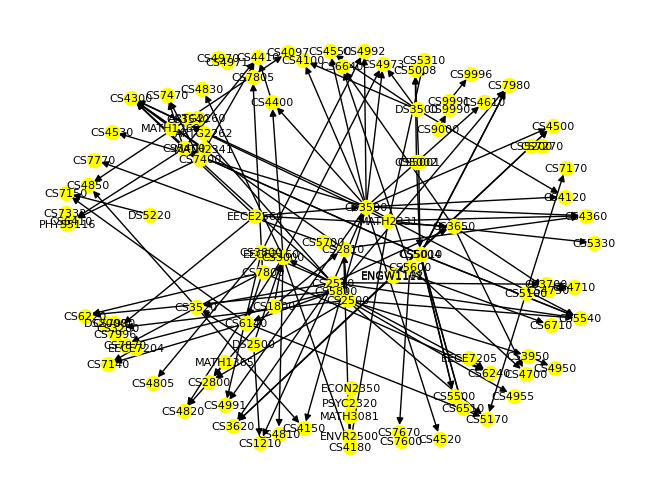

In [17]:
'''
Create a DAG from a given set of courses and their prerequisites.

Inputs
------
courses_to_prereqs: dictionary with courses as keys and lists of prerequisites as values

Outputs
-------
G: a DAG with a node for each course, and edges between courses that are prerequisites for other courses
'''
def course_prereqs(courses_to_prereqs: dict):
    G = nx.DiGraph()
    for k,v in courses_to_prereqs.items():
        edges = [(val,k) for val in v]
        G.add_edges_from(edges)
        
    return G

# example usage
nx.draw(course_prereqs(get_prereqs('cs')), with_labels=True, node_size=100, node_color='yellow', font_size=8)

#### c) Finding the department with the most prerequisites per course

Note: This metric is not perfect, as many of the prerequisites listed in the catalog have an 'OR' relationship. That means that the department output by the code below is the one with the most prerequisites listed, and not necessarily the department that requires the most actual prerequisites required in order to be able to take an average course. 

In [18]:
'''
Get all department codes.

Outputs
-------
codes: a list of all NEU department codes
'''
def get_dept_codes() -> list[str]:
    codes = []
    
    catalog_res = requests.get('https://catalog.northeastern.edu/course-descriptions/')
    catalog_html = catalog_res.text
    catalog_soup = BeautifulSoup(catalog_html)

    atoz_soup = catalog_soup.find('div', id='atozindex')
    dept_lists_soup = atoz_soup.find_all('ul')
    for l in dept_lists_soup:
        depts_soup = l.find_all('li')
        for li in depts_soup:
            codes.append(li.a.get('href').split('/')[-2])
            
    return codes

'''
Find the department with the most prerequisites per course. Skip departments that are not formatted in an expected manner.

Outputs
-------
max: the department code with the most prerequisties per course listed in the catalog
'''
def most_prereqs() -> str:
    avg_prereqs = {}

    for code in get_dept_codes():
        try:
            courses_to_prereqs = get_prereqs(code)
            count_prs = 0
            for _, prs in courses_to_prereqs.items():
                count_prs += len(prs)
            avg = count_prs / len(courses_to_prereqs)
            avg_prereqs[code] = avg
        except:
            continue


    return max(avg_prereqs, key= lambda x: avg_prereqs[x])

print('Department with the most prerequisites per course: ' + str(most_prereqs()))

Department with the most prerequisites per course: anth


#### d) Finding the longest chain of prerequisites

In [19]:
'''
Find the longest chain of prerequisites from all departments. Skip departments that are not formatted in an expected manner.

Outputs
-------
max_chain: a list containing the longest chain of courses found among all departments.
'''
def longest_chain() -> list:
    max_chain = []

    for code in get_dept_codes():
        try:
            courses_to_prereqs = get_prereqs(code)
            G = course_prereqs(courses_to_prereqs)
            longest_path = nx.dag_longest_path(G)
            if len(longest_path) > len(max_chain):
                max_chain = cp.deepcopy(longest_path)
        except Exception as e:
            continue

    return max_chain

print('Longest chain of prerequisites: ' + str(longest_chain()))

Longest chain of prerequisites: ['PT6330', 'PT6340', 'PT5138', 'PT5150', 'PT5540', 'PT5505', 'PT5230', 'PT6441', 'PT6442', 'PT6448']


#### e) Questions for each dataset

I'm not sure I fully understand what this question is asking. I think it's saying - look at the different networks that we created from the same data and talk about that a bit. It is really cool that from one simple website, we can create such different networks. If I were wanting to know about the language and tone of the program catalogs, the class exercise would be a good start. If I want to know about the structure and requirements for courses, the network I created here would be much more useful. 

Though this seems obvious as I write it, I think it's easy to think of making "a network of the data", in a way that makes it seem like there's one correct way to create a graph. This is not true at all, and emphasizes the idea that a lot of thought has to go into the way that we collect, store, and analyze data.


### Question 5

All code is my own. I used ChatGPT for help with plotting the subplots in the way that I wanted.

#### a) Describing the network

I chose the Euroroad (https://networkrepository.com/road-euroroad.php) dataset. This dataset is a collection of European cities (nodes) and E-roads that connect them (edges), and has ~1.1k nodes. E-roads are part of a system called the International E-road network, which numbers certain European roads that cross international borders (https://en.wikipedia.org/wiki/International_E-road_network). I couldn't find exactly who made it, or how it was made, so I am considering the link to the dataset as sufficient citation. 

#### b) Comparing to a randomized network

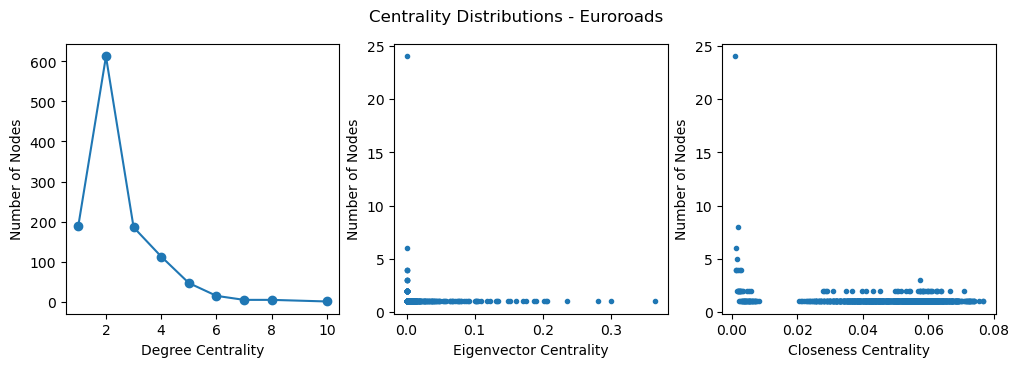

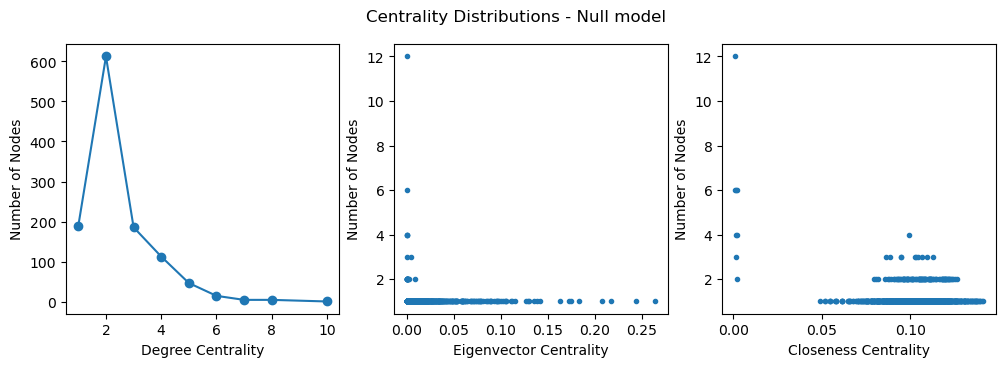

In [38]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import rc
from collections import Counter

G = nx.read_edgelist('../road-euroroad.edges')

fig, ax = plt.subplots(1,3,figsize=(12,3.5))

cent_labels = ['degree centrality',
               'eigenvector centrality',
               'closeness centrality']

cents = dict(nx.degree(G))
centrality_counts = Counter(cents.values())
sorted_centralities = sorted(centrality_counts.items())
x_values, y_values = zip(*sorted_centralities)

# Plot the degree centrality vs. number of nodes
ax[0].plot(x_values, y_values, marker='o', linestyle='-')

# Add labels and title
ax[0].set_xlabel('Degree Centrality')
ax[0].set_ylabel('Number of Nodes')

cents = dict(nx.eigenvector_centrality(G, max_iter=300))
centrality_counts = Counter(cents.values())
sorted_centralities = sorted(centrality_counts.items())
x_values, y_values = zip(*sorted_centralities)

# Plot the degree centrality vs. number of nodes
ax[1].scatter(x_values, y_values, marker='.')

# Add labels and title
ax[1].set_xlabel('Eigenvector Centrality')
ax[1].set_ylabel('Number of Nodes')

cents = dict(nx.closeness_centrality(G))
centrality_counts = Counter(cents.values())
sorted_centralities = sorted(centrality_counts.items())
x_values, y_values = zip(*sorted_centralities)

# Plot the degree centrality vs. number of nodes
ax[2].scatter(x_values, y_values, marker='.')

# Add labels and title
ax[2].set_xlabel('Closeness Centrality')
ax[2].set_ylabel('Number of Nodes')
  
# Show the plot
fig.suptitle('Centrality Distributions - Euroroads')
fig.show()

# null model plots

# create null model by randomly swapping edges while preserving degrees
null_model = nx.double_edge_swap(G, nswap=G.number_of_edges(), max_tries=200000)

fig2, ax2 = plt.subplots(1,3,figsize=(12,3.5))

cent_labels = ['degree centrality',
               'eigenvector centrality',
               'closeness centrality']

cents = dict(nx.degree(null_model))
centrality_counts = Counter(cents.values())
sorted_centralities = sorted(centrality_counts.items())
x_values, y_values = zip(*sorted_centralities)

# Plot the degree centrality vs. number of nodes
ax2[0].plot(x_values, y_values, marker='o', linestyle='-')

# Add labels and title
ax2[0].set_xlabel('Degree Centrality')
ax2[0].set_ylabel('Number of Nodes')

cents = dict(nx.eigenvector_centrality(null_model, max_iter=500))
centrality_counts = Counter(cents.values())
sorted_centralities = sorted(centrality_counts.items())
x_values, y_values = zip(*sorted_centralities)

# Plot the degree centrality vs. number of nodes
ax2[1].scatter(x_values, y_values, marker='.')

# Add labels and title
ax2[1].set_xlabel('Eigenvector Centrality')
ax2[1].set_ylabel('Number of Nodes')

cents = dict(nx.closeness_centrality(null_model))
centrality_counts = Counter(cents.values())
sorted_centralities = sorted(centrality_counts.items())
x_values, y_values = zip(*sorted_centralities)

# Plot the degree centrality vs. number of nodes
ax2[2].scatter(x_values, y_values, marker='.')

# Add labels and title
ax2[2].set_xlabel('Closeness Centrality')
ax2[2].set_ylabel('Number of Nodes')
  
# Show the plot
fig2.suptitle('Centrality Distributions - Null model')
fig2.show()

#### c) Discussing similarities and differences

I chose to look at different centrality measures for both the Euroroad dataset and the null model that I generated from it. 

As expected, degree centralities between the two are the same. This is because the instructions specified that I should maintain degree distributions. However, when the null model was created by swapping edges, the eigenvector centrality and closeness centrality of the graphs differed. In particular, we see that with the null model, there was a higher concentration of low-centrality nodes as compared to the Euroroad model. I hypothesize that this is because it is unlikely to randomly generate a node that has way more centrality than other nodes. As for closeness centrality, we see something that almost looks like a more "normal" distribution - I would guess that this is because increased randomness would cause closeness to normalize somewhat. 

Null models are useful for trying to figure out if a network's properties happened by chance. If we see similar results from a null model, this should lead us to ask some questions - can we actually draw conclusions about the network when it seems that the properties could be happening by chance? In this particular network, we can see that some measures, especially closeness centrality, look very different between the original and null models.